In [1]:
#Import in all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [2]:
#Import Insurance Regression Data and describe the data
df = pd.read_csv(r"c:\Users\rmhs\OneDrive - Capco\Desktop\ADS\Rajsi ADS\Regression\data\insurance_regression.csv")
print(df.head(10))
df.info()
df. describe()

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  northwest  28923.13692
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   flo

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [3]:
#Feature Engineering to ensure all data is model-ready
# Change all object *text* data to numerical - note variables are categorical
print(df["sex"].unique())
print(df["smoker"].unique())
print(df["region"].unique())

['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


In [4]:
#rename variable sex to gender
df = df.rename(columns={"sex": "gender"})

In [5]:
#create copy of data
df_change = df.copy()

#convert smoker and sex - binary categorical- to numerical 1,0
df_change["smoker"] = df_change["smoker"].map({"yes": 1, "no":0})
df_change["gender"] = df_change["gender"].map({"male":0, "female":1})
#convert region to nominal numerical with label encoding - not one-hot encoding (to ensure everything stays in one column)
df_change["region_encoded"] = le.fit_transform(df_change["region"])
#drop the original text region - not going to be used for model
df_2 = df_change.drop("region", axis=1)


In [6]:
# rename variable sex to gender and region_encoded to region
df_2 = df_2.rename(columns={"region_encoded": "region"})

In [7]:
df_2.info()
df_2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   charges   1338 non-null   float64
 6   region    1338 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 73.3 KB


,age,gender,bmi,children,smoker,charges,region
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,13270.422265,1.515695
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,1.104885
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,1.000000
50%,39.000000,0.000000,30.400000,1.000000,0.000000,9382.033000,2.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,2.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,3.000000


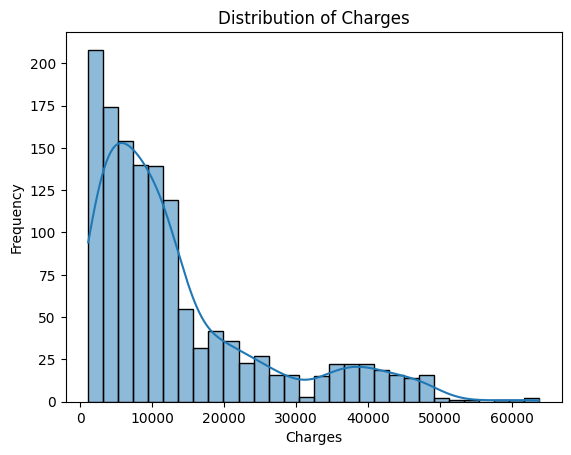

In [8]:
#EDA - Exploratory Feature Analysis - used to understand data structure and relationships
# Charges is Target Variable

#Target variable distribution
sns.histplot(df["charges"], kde=True)
plt.title("Distribution of Charges")
plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.show()

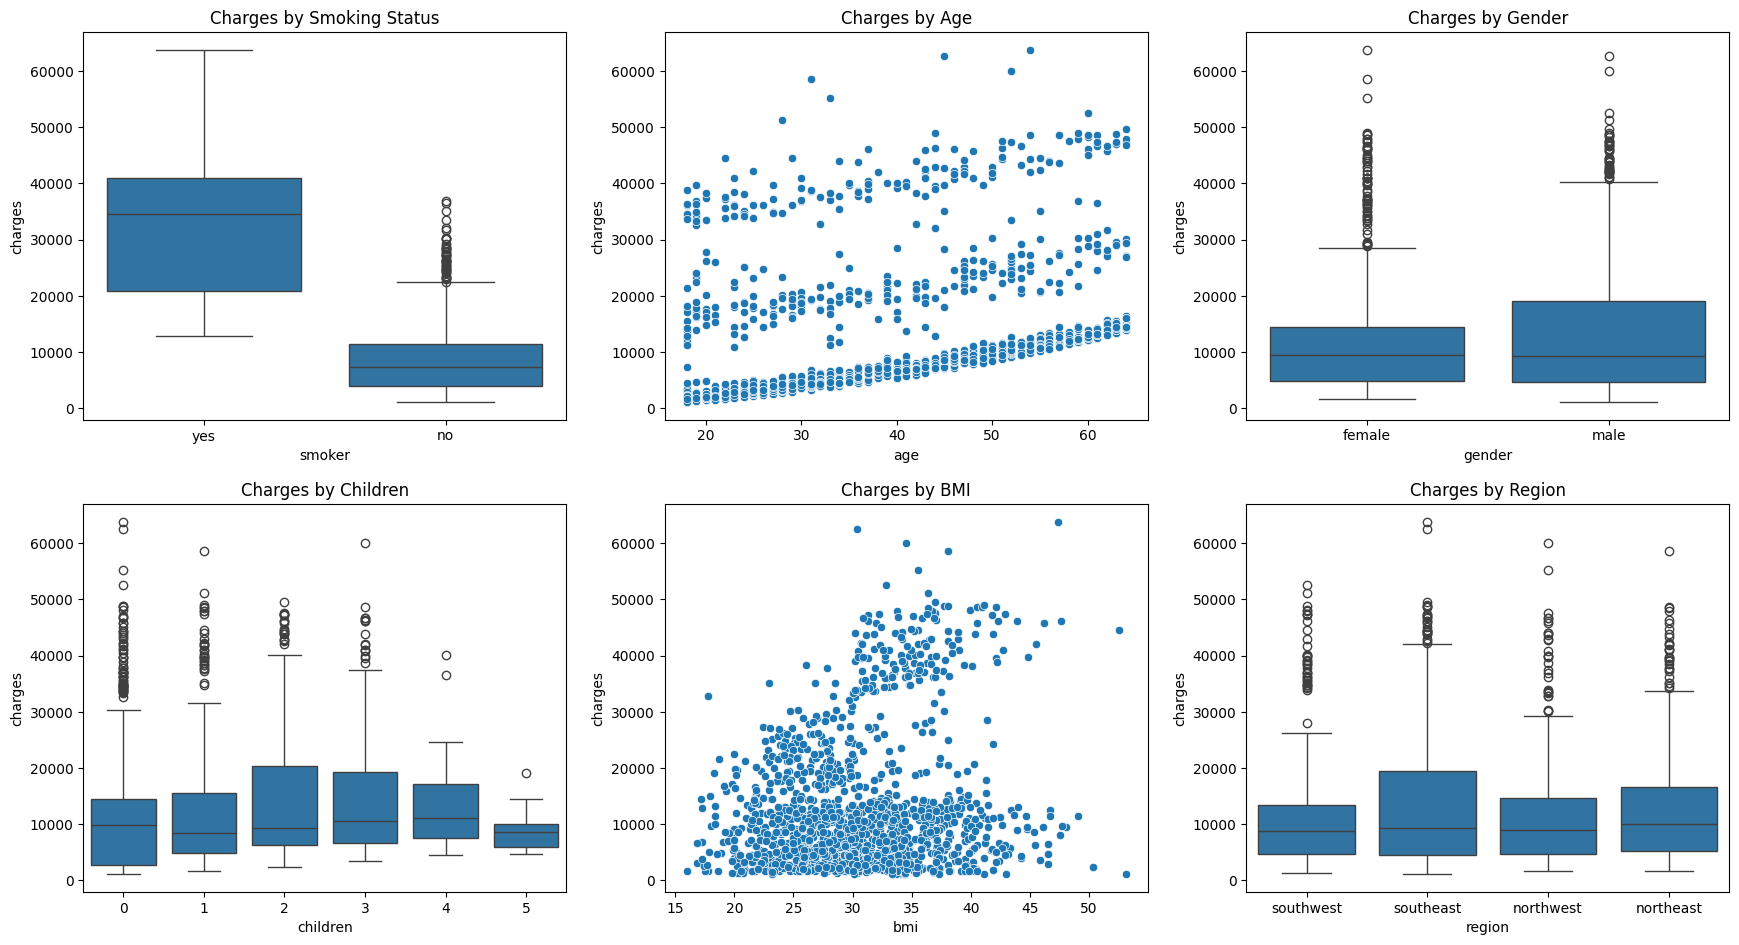

In [9]:
# Running all INDIVIDUAL variables against charges to see which has most impact against target variable
# Set figure size and layout
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
plt.tight_layout(pad=4.0)

# Plot 1: Smoker
sns.boxplot(x="smoker", y="charges", data=df, ax=axes[0, 0])
axes[0, 0].set_title("Charges by Smoking Status")

# Plot 2: Age
sns.scatterplot(x="age", y="charges", data=df, ax=axes[0, 1])
axes[0, 1].set_title("Charges by Age")

# Plot 3: Gender
sns.boxplot(x="gender", y="charges", data=df, ax=axes[0, 2])
axes[0, 2].set_title("Charges by Gender")

# Plot 4: Children
sns.boxplot(x="children", y="charges", data=df, ax=axes[1, 0])
axes[1, 0].set_title("Charges by Children")

# Plot 5: BMI
sns.scatterplot(x="bmi", y="charges", data=df, ax=axes[1, 1])
axes[1, 1].set_title("Charges by BMI")

# Plot 6: Region
sns.boxplot(x="region", y="charges", data=df, ax=axes[1, 2])
axes[1, 2].set_title("Charges by Region")

# Show all plots at once
plt.show()

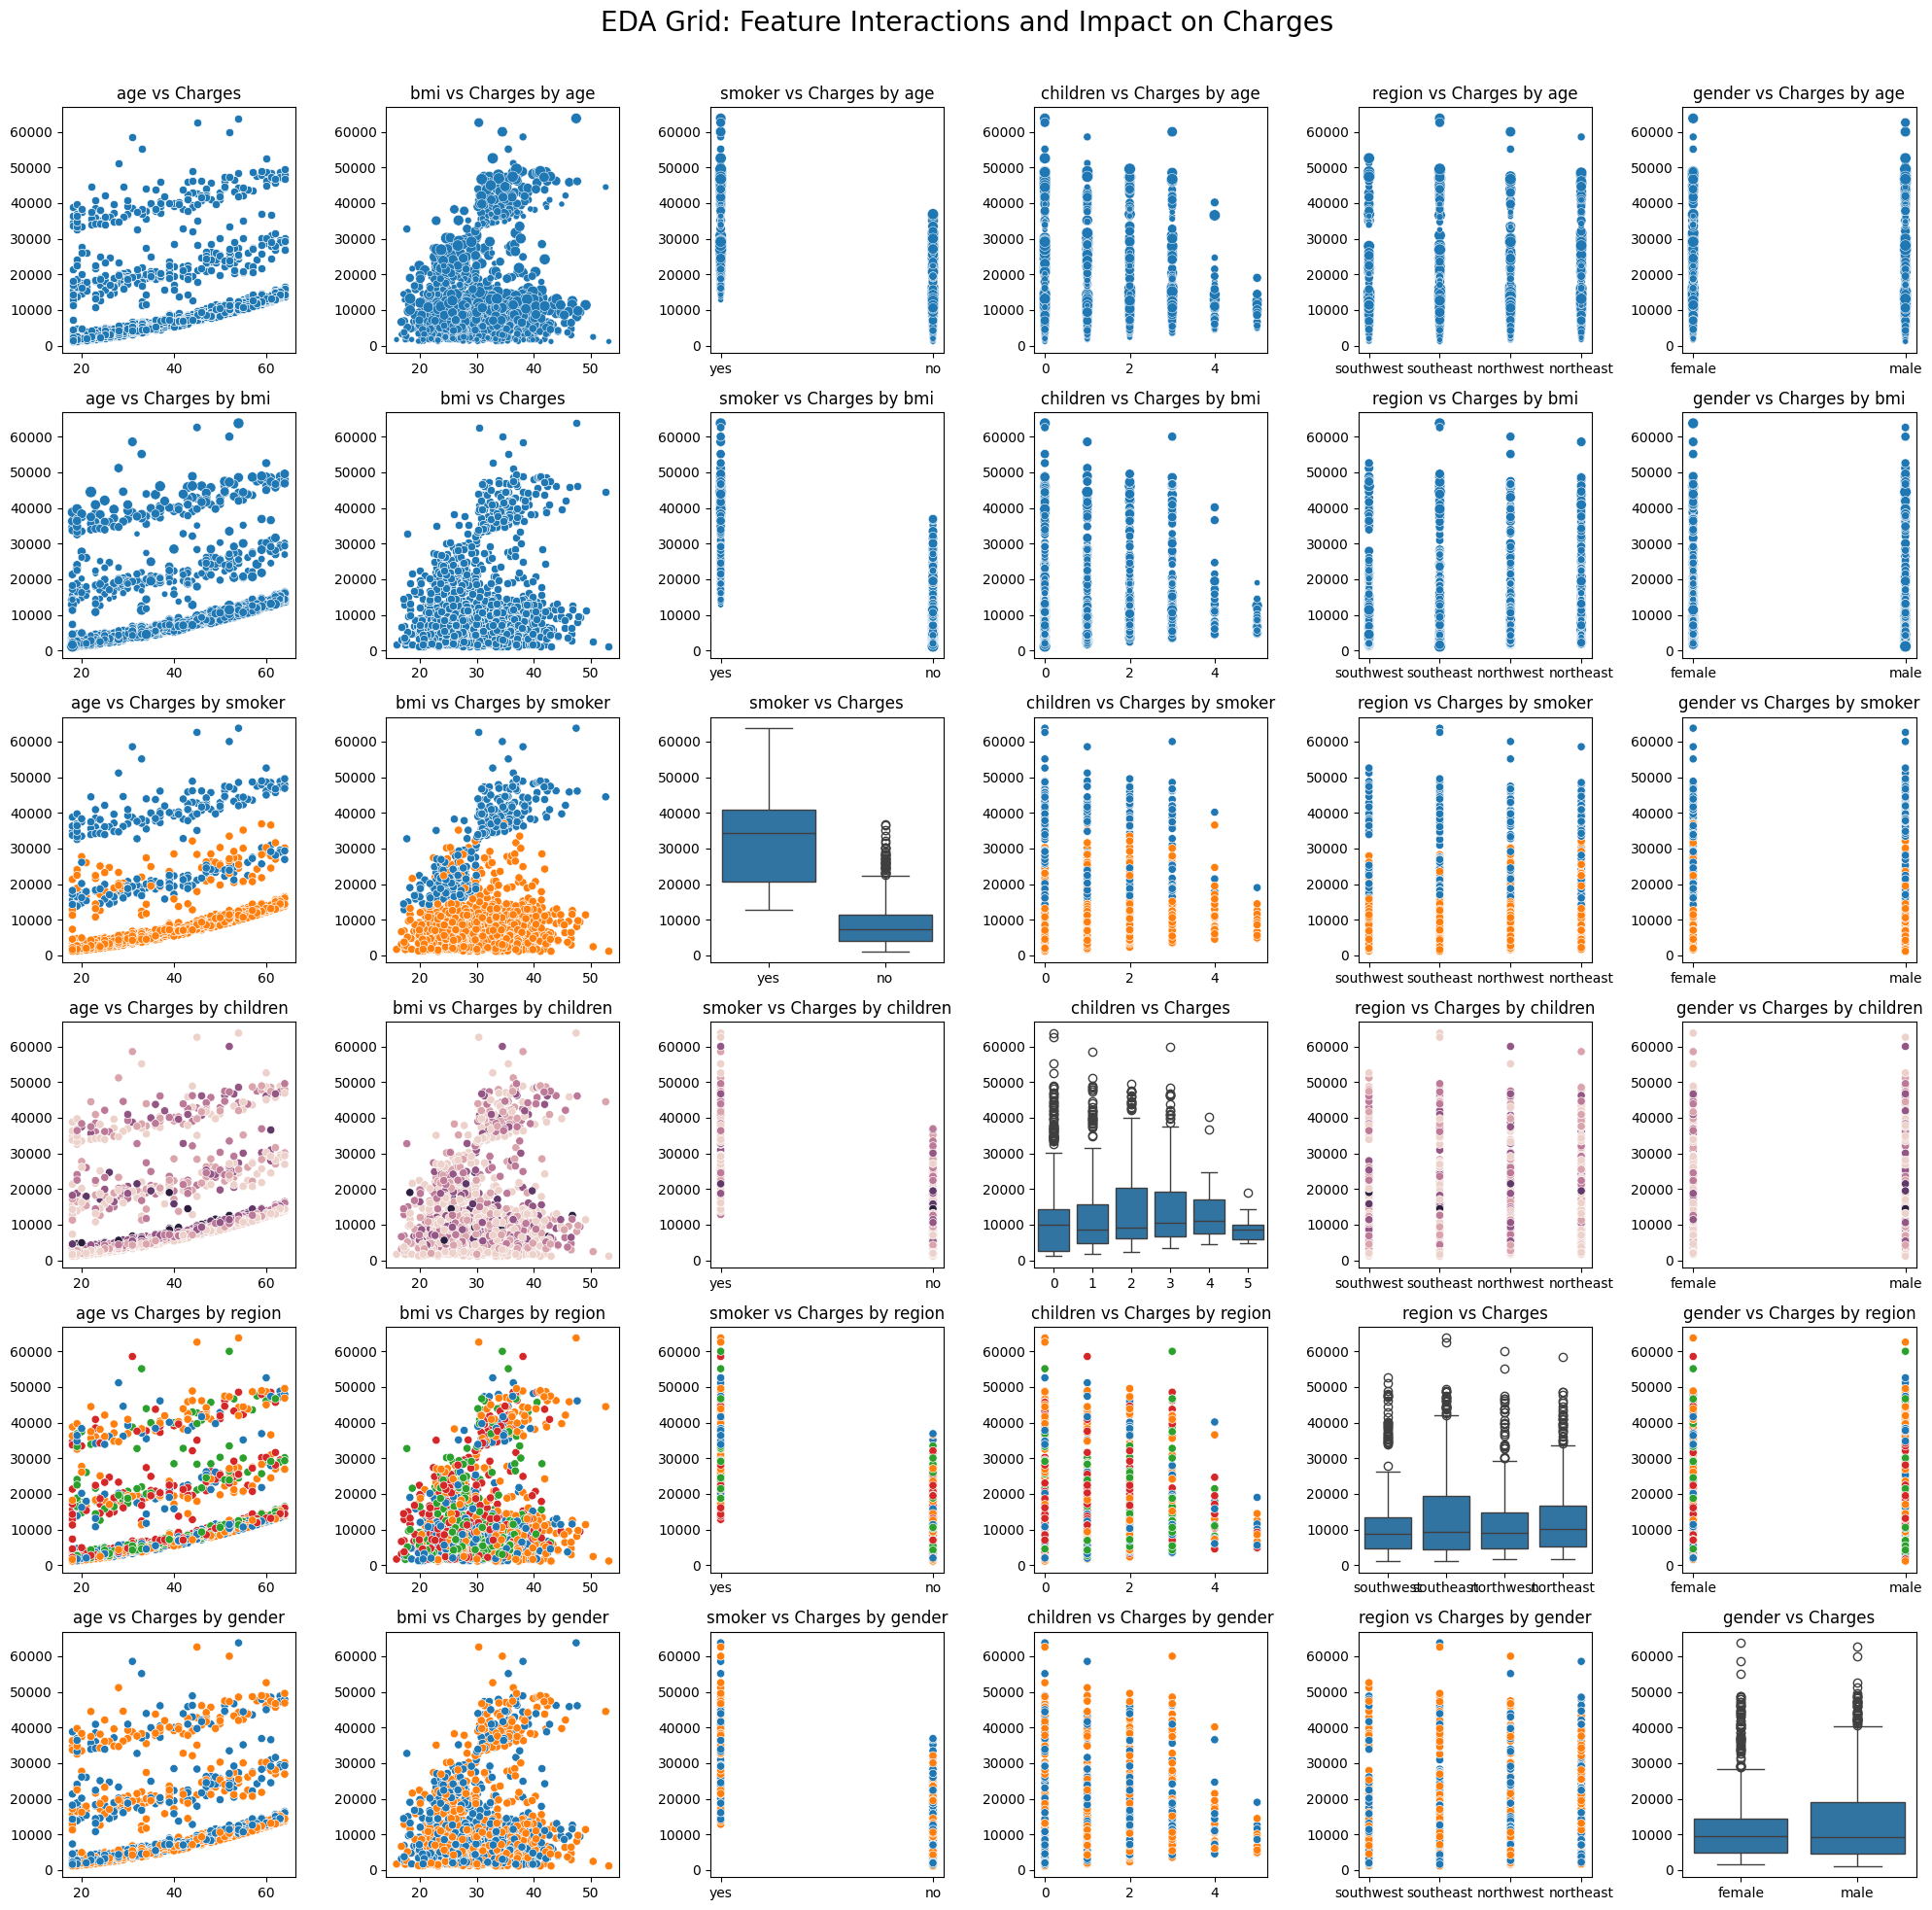

In [10]:
# Select 6 features (adjust as needed)
features = ["age", "bmi", "smoker", "children", "region", "gender"]
n = len(features)

fig, axes = plt.subplots(n, n, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        x = features[j]
        hue = features[i]

        # Diagonal: plot x vs charges (alone)
        if i == j:
            if df[x].dtype == "object" or df[x].nunique() < 10:
                sns.boxplot(x=x, y="charges", data=df, ax=ax)
            else:
                sns.scatterplot(x=x, y="charges", data=df, ax=ax)
            ax.set_title(f"{x} vs Charges")
        
        # Off-diagonal: interaction plots
        else:
            if df[hue].dtype == "object" or df[hue].nunique() < 10:
                sns.scatterplot(x=x, y="charges", hue=hue, data=df, ax=ax, legend=False)
            else:
                sns.scatterplot(x=x, y="charges", size=hue, data=df, ax=ax, legend=False)
            ax.set_title(f"{x} vs Charges by {hue}")

        ax.set_xlabel("")
        ax.set_ylabel("")

plt.suptitle("EDA Grid: Feature Interactions and Impact on Charges", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


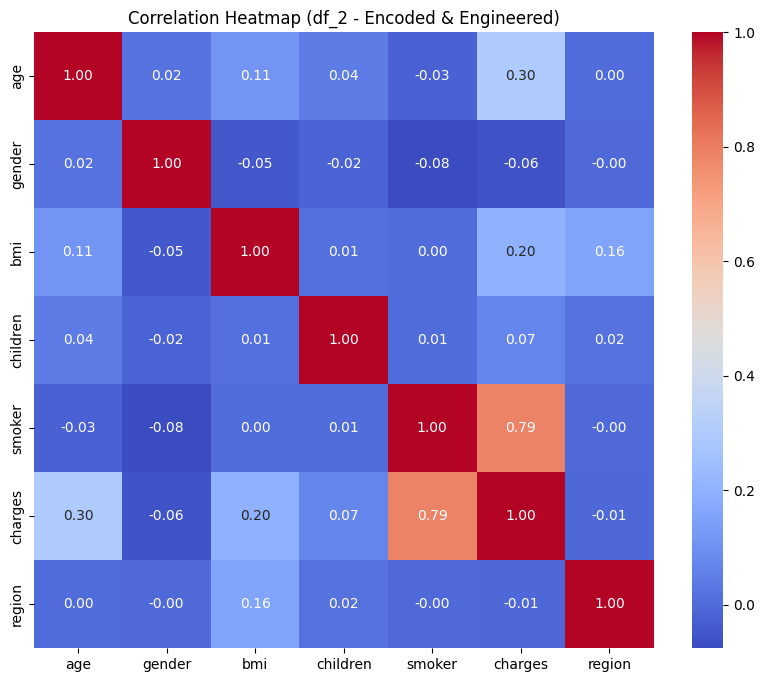

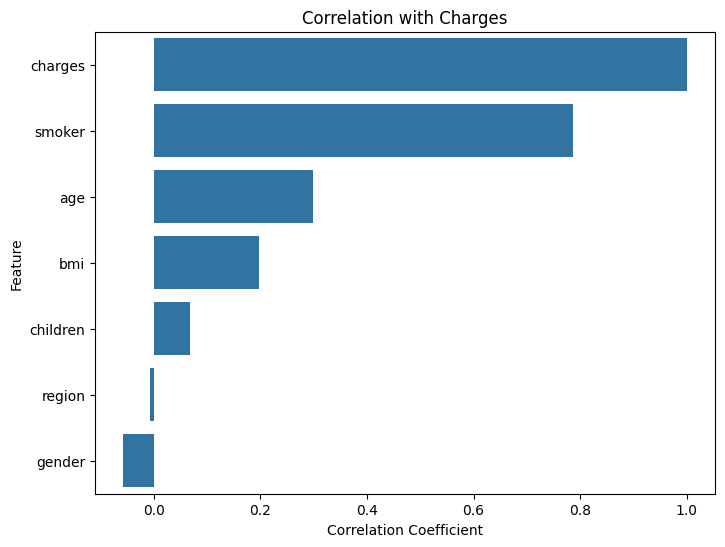

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
region     -0.006208
gender     -0.057292
Name: charges, dtype: float64

In [11]:
#basic heatmap with target correlation
# Compute correlation matrix (only numeric columns)
corr = df_2.corr(numeric_only=True)

# Sort by correlation with target (optional but useful)
corr_target = corr["charges"].sort_values(ascending=False)

# Plot full heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (df_2 - Encoded & Engineered)")
plt.show()

# Plot only correlations with charges
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title("Correlation with Charges")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

corr = df_2.corr(numeric_only=True)
corr["charges"].sort_values(ascending=False)

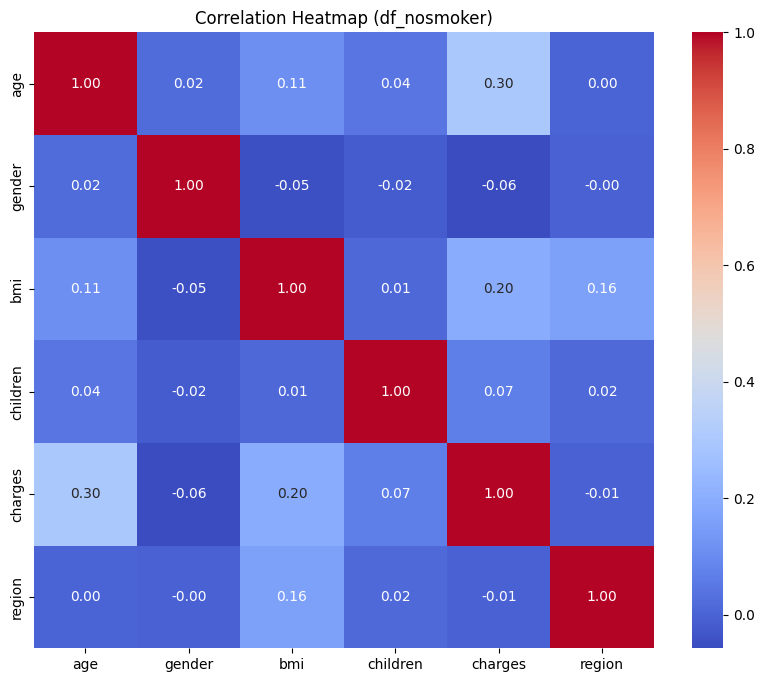

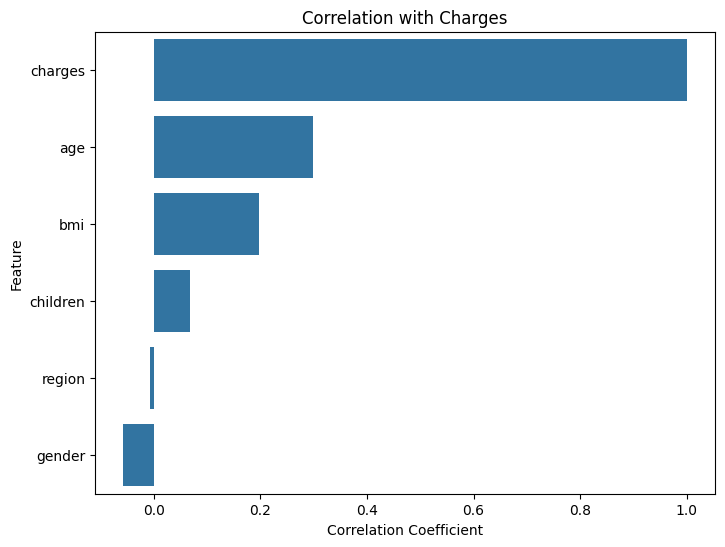

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
region     -0.006208
gender     -0.057292
Name: charges, dtype: float64

In [12]:
#EDA shows that Smoker is a huge impact on charges - drop smoker from the dataset and see if anything else has a strong interaction

df_nosmoker = df_2.drop("smoker", axis=1)

#basic heatmap with target correlation
# Compute correlation matrix (only numeric columns)
corr_nonsmoker = df_nosmoker.corr(numeric_only=True)

# Sort by correlation with target (optional but useful)
corr_targetns = corr_nonsmoker["charges"].sort_values(ascending=False)

# Plot full heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_nonsmoker, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (df_nosmoker)")
plt.show()

# Plot only correlations with charges
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_targetns.values, y=corr_targetns.index)
plt.title("Correlation with Charges")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

corr_ns = df_nosmoker.corr(numeric_only=True)
corr_ns["charges"].sort_values(ascending=False)

In [13]:
df_model = df_2.copy()
print(df_model.shape)
print(df_model.columns)

(1338, 7)
Index(['age', 'gender', 'bmi', 'children', 'smoker', 'charges', 'region'], dtype='object')


In [14]:
# A: Full feature set (including 'smoker')
X_full = df_model.drop("charges", axis=1)

# B: Reduced feature set (excluding 'smoker' and optionally 'bmi_smoker' if it exists)
X_nosmoker = df_model.drop(["charges", "smoker"], axis=1)

# Target
y = df_model["charges"]

In [15]:
# Full version
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=13)

# Reduced version
X_train_nosmoker, X_test_nosmoker, y_train_nosmoker,y_test_nosmoker = train_test_split(X_nosmoker, y, test_size=0.3, random_state=13)

In [16]:
# Model A: With smoker
rf_full = RandomForestRegressor(random_state=13)
rf_full.fit(X_train_full, y_train)
pred_full = rf_full.predict(X_test_full)

# Model B: Without smoker
rf_nosmoker = RandomForestRegressor(random_state=13)
rf_nosmoker.fit(X_train_nosmoker, y_train_nosmoker)
pred_nosmoker = rf_nosmoker.predict(X_test_nosmoker)

In [17]:
print("RF Model A (all features):")
print("R²:", r2_score(y_test, pred_full))
print("MAE:", mean_absolute_error(y_test, pred_full))

print("RF Model B (without smoker):")
print("R²:", r2_score(y_test, pred_nosmoker))
print("MAE:", mean_absolute_error(y_test_nosmoker, pred_nosmoker))

RF Model A (all features):
R²: 0.8738100917345621
MAE: 2420.841167907633
RF Model B (without smoker):
R²: -0.02665487716956827
MAE: 9396.358403768223


In [18]:
importances_full = pd.Series(rf_full.feature_importances_, index=X_full.columns)
importances_nosmoker = pd.Series(rf_nosmoker.feature_importances_, index=X_nosmoker.columns)

# Side-by-side comparison
comparison_df = pd.DataFrame({
    "With Smoker": importances_full,
    "Without Smoker": importances_nosmoker
}).sort_values("With Smoker", ascending=False)

print(comparison_df)

          With Smoker  Without Smoker
smoker       0.605564             NaN
bmi          0.213577        0.425379
age          0.136898        0.324387
children     0.022599        0.110549
region       0.015777        0.090876
gender       0.005586        0.048809


<Figure size 1000x600 with 0 Axes>

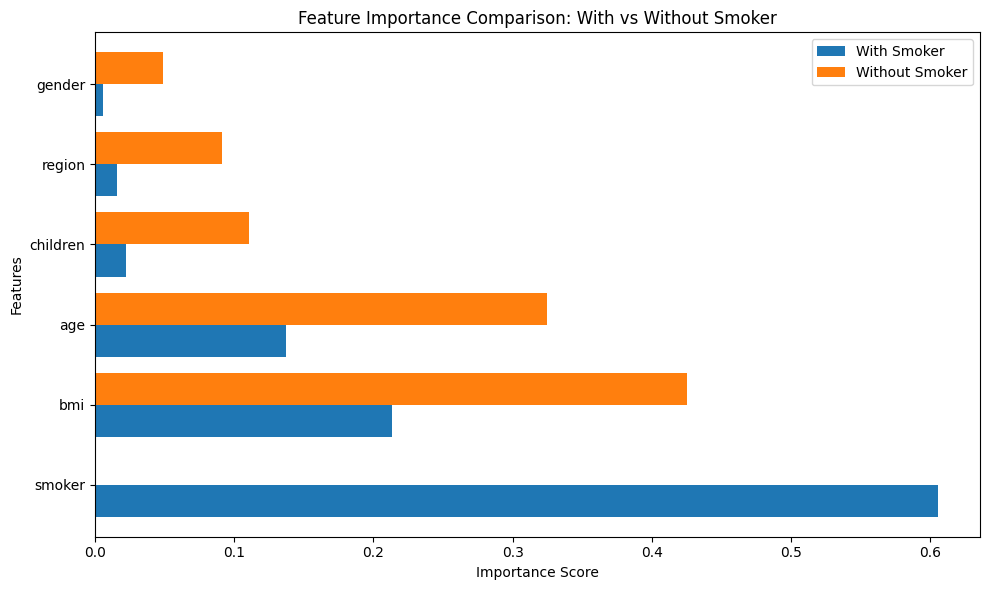

In [19]:
plt.figure(figsize=(10, 6))
comparison_df.plot(kind="barh", figsize=(10, 6), width=0.8)

plt.title("Feature Importance Comparison: With vs Without Smoker")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

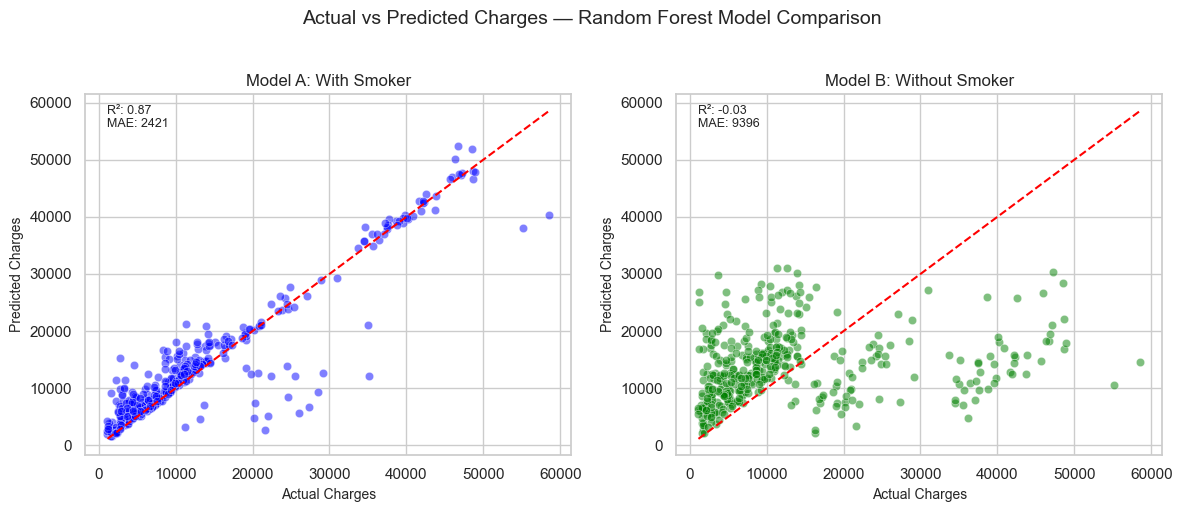

In [20]:
r2_full = r2_score(y_test, pred_full)
r2_nosmoker = r2_score(y_test_nosmoker, pred_nosmoker)

mae_full = mean_absolute_error(y_test, pred_full)
mae_nosmoker = mean_absolute_error(y_test_nosmoker, pred_nosmoker)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# --- Plot 1: With Smoker ---
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=pred_full, alpha=0.5, color='blue', ax=ax1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Model A: With Smoker", fontsize=12)
plt.xlabel("Actual Charges", fontsize=10)
plt.ylabel("Predicted Charges", fontsize=10)
plt.text(y_test.min(), y_test.max()*0.95, f"R²: {r2_full:.2f}\nMAE: {mae_full:.0f}", fontsize=9)

# --- Plot 2: Without Smoker ---
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=pred_nosmoker, alpha=0.5, color='green', ax=ax2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Model B: Without Smoker", fontsize=12)
plt.xlabel("Actual Charges", fontsize=10)
plt.ylabel("Predicted Charges", fontsize=10)
plt.text(y_test.min(), y_test.max()*0.95, f"R²: {r2_nosmoker:.2f}\nMAE: {mae_nosmoker:.0f}", fontsize=9)

plt.suptitle("Actual vs Predicted Charges — Random Forest Model Comparison", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()